# 0.引入必要的库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# 设置中文字体和显示格式
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
print("已就绪")

已就绪


# 1. 数据准备和预处理

In [20]:
'''
def load_and_preprocess_data():
    """加载数据并进行预处理"""
    
    # 加载数据 - 修正参数
    boston = pd.read_csv(r"D:\house_data.csv")  # 自动识别列名和分隔符
    
    # 或者明确指定参数（更安全的方式）
    # boston = pd.read_csv(r"D:\house_data.csv", header=0)  # header=0表示第一行是列名
    
    # 分离特征和目标变量
    X = boston[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']].values
    y = boston['MEDV'].values.reshape(-1, 1)
    
    print(f"数据集形状: X {X.shape}, y {y.shape}")
    print(f"特征列名: {boston.columns.tolist()}")
    return X, y
'''

def load_and_preprocess_data():
    """加载数据并进行预处理"""
    
    # 加载数据
    boston = pd.read_csv(r"D:\house_data.csv")  # 自动识别列名和分隔符
    
    # 分离特征和目标变量
    X = boston[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']].values
    y = boston['MEDV'].values.reshape(-1, 1)
    
    print(f"数据集形状: X {X.shape}, y {y.shape}")
    print(f"特征列名: {boston.columns.tolist()}")
    
    # 🔥 修改：返回 boston DataFrame
    return boston, X, y

def feature_scaling(X, y):
    """特征缩放 - 加速梯度下降收敛"""
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    # 添加偏置项 (x0 = 1)
    X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])
    
    return X_scaled, y_scaled, scaler_X, scaler_y

# 2. 梯度下降核心函数

In [21]:
def compute_cost(X, y, theta):
    """计算损失函数（均方误差）"""
    m = len(y)
    predictions = X.dot(theta)
    cost = (1/(2*m)) * np.sum(np.square(predictions - y))
    return cost


def closed_form_solution(X, y):
    """闭合形式求解线性回归参数"""
    # 添加偏置项（如果尚未添加）
    if X.shape[1] == 13:  # 如果没有偏置项
        X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # 计算解析解: theta = (X^T X)^(-1) X^T y
    try:
        theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        print("闭合形式求解成功")
    except np.linalg.LinAlgError:
        print("矩阵不可逆，使用伪逆")
        theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
    
    return theta

# 在比较函数中添加闭合形式求解
def compare_all_methods():
    """比较所有方法"""
    # 现有代码...
    
    # 添加闭合形式求解
    print(f"\n{'='*50}")
    print(f"开始执行: 闭合形式求解")
    print(f"{'='*50}")
    
    theta_closed_form = closed_form_solution(X_scaled[:, 1:], y_scaled)  # 去掉偏置项再添加
    y_pred_cf, r2_cf, mse_cf = evaluate_model(X_scaled, y_scaled, theta_closed_form, scaler_y)
    
    results['闭合形式求解'] = {
        'theta': theta_closed_form,
        'cost_history': [compute_cost(X_scaled, y_scaled, theta_closed_form)],  # 单次计算
        'r2': r2_cf,
        'mse': mse_cf,
        'y_pred': y_pred_cf
    }

    
def gradient_descent(X, y, theta, alpha, iterations, verbose=True):
    """执行梯度下降"""
    m = len(y)
    cost_history = []
    
    for i in range(iterations):
        # 计算预测值
        predictions = X.dot(theta)
        
        # 计算梯度
        errors = predictions - y
        gradient = (1/m) * X.T.dot(errors)
        
        # 更新参数
        theta = theta - alpha * gradient
        
        # 记录损失
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)
        
        # 每100次迭代打印进度
        if verbose and i % 100 == 0:
            print(f"迭代 {i}: 损失 = {cost:.6f}")
    
    return theta, cost_history

def stochastic_gradient_descent(X, y, theta, alpha, iterations, verbose=True):
    """随机梯度下降"""
    m = len(y)
    cost_history = []
    
    for i in range(iterations):
        total_cost = 0
        for j in range(m):
            # 随机选择一个样本
            random_index = np.random.randint(m)
            xi = X[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            
            # 计算梯度（单个样本）
            prediction = xi.dot(theta)
            error = prediction - yi
            gradient = xi.T.dot(error)
            
            # 更新参数
            theta = theta - alpha * gradient
            
            # 计算当前损失
            total_cost += compute_cost(xi, yi, theta)
        
        avg_cost = total_cost / m
        cost_history.append(avg_cost)
        
        if verbose and i % 100 == 0:
            print(f"迭代 {i}: 平均损失 = {avg_cost:.6f}")
    
    return theta, cost_history

def mini_batch_gradient_descent(X, y, theta, alpha, iterations, batch_size=32, verbose=True):
    """小批量梯度下降"""
    m = len(y)
    cost_history = []
    
    for i in range(iterations):
        # 打乱数据
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        total_cost = 0
        batch_count = 0
        
        for j in range(0, m, batch_size):
            # 获取小批量数据
            end_idx = min(j + batch_size, m)
            X_batch = X_shuffled[j:end_idx]
            y_batch = y_shuffled[j:end_idx]
            
            batch_m = len(y_batch)
            
            # 计算梯度
            predictions = X_batch.dot(theta)
            errors = predictions - y_batch
            gradient = (1/batch_m) * X_batch.T.dot(errors)
            
            # 更新参数
            theta = theta - alpha * gradient
            
            # 计算当前批次的损失
            batch_cost = compute_cost(X_batch, y_batch, theta)
            total_cost += batch_cost
            batch_count += 1
        
        avg_cost = total_cost / batch_count if batch_count > 0 else total_cost
        cost_history.append(avg_cost)
        
        if verbose and i % 100 == 0:
            print(f"迭代 {i}: 平均损失 = {avg_cost:.6f}")
    
    return theta, cost_history

def evaluate_model(X, y, theta, scaler_y):
    """评估模型性能"""
    # 预测
    y_pred_scaled = X.dot(theta)
    
    # 反标准化预测结果
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y)
    
    # 计算R²分数
    r2 = r2_score(y_true, y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    
    print(f"模型评估结果:")
    print(f"R²分数: {r2:.4f}")
    print(f"均方误差: {mse:.4f}")
    
    return y_pred, r2, mse

def plot_results(y_true, y_pred, cost_history, method_name):
    """绘制结果图表"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # 预测值 vs 真实值
    axes[0].scatter(y_true, y_pred, alpha=0.6)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_xlabel('真实价格')
    axes[0].set_ylabel('预测价格')
    axes[0].set_title(f'{method_name} - 预测 vs 真实值')
    axes[0].grid(True)
    
    # 损失函数下降曲线
    axes[1].plot(cost_history)
    axes[1].set_xlabel('迭代次数')
    axes[1].set_ylabel('损失')
    axes[1].set_title(f'{method_name} - 损失函数下降曲线')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

def compare_gradient_descent_methods():
    """比较不同梯度下降方法"""
    # 加载和预处理数据 - 现在接收3个返回值
    boston, X, y = load_and_preprocess_data()
    X_scaled, y_scaled, scaler_X, scaler_y = feature_scaling(X, y)
    
    # 初始化参数
    theta_initial = np.zeros((X_scaled.shape[1], 1))
    
    methods = {
        '批量梯度下降': (gradient_descent, {'alpha': 0.01, 'iterations': 1000}),
        '随机梯度下降': (stochastic_gradient_descent, {'alpha': 0.01, 'iterations': 1000}),
        '小批量梯度下降': (mini_batch_gradient_descent, {'alpha': 0.01, 'iterations': 1000, 'batch_size': 32})
    }
    
    results = {}
    
    for method_name, (method_func, params) in methods.items():
        print(f"\n{'='*50}")
        print(f"开始执行: {method_name}")
        print(f"{'='*50}")
        
        # 复制初始参数
        theta = theta_initial.copy()
        
        # 执行梯度下降
        theta_final, cost_history = method_func(X_scaled, y_scaled, theta, **params)
        
        # 评估模型
        y_pred, r2, mse = evaluate_model(X_scaled, y_scaled, theta_final, scaler_y)
        
        # 存储结果
        results[method_name] = {
            'theta': theta_final,
            'cost_history': cost_history,
            'r2': r2,
            'mse': mse,
            'y_pred': y_pred
        }
        
        # 绘制结果
        plot_results(scaler_y.inverse_transform(y_scaled), y_pred, cost_history, method_name)
        
        print(f"{method_name} 最终参数形状: {theta_final.shape}")
        print(f"{method_name} 完成!")
    
    # 🔥 修正：return 语句应该在循环外部，返回6个值
    return boston, results, X_scaled, y_scaled, scaler_X, scaler_y
    

# 3. 模型评估和可视化


In [22]:
def analyze_feature_correlation(boston, theta, feature_names):
    """分析特征与目标变量的相关性"""
    print(f"\n{'='*60}")
    print("特征相关性分析:")
    print(f"{'='*60}")
    
    # 参数theta[1:]对应各个特征的权重（去掉偏置项）
    feature_weights = theta[1:].flatten()
    
    print("特征权重 (标准化后):")
    for i, (name, weight) in enumerate(zip(feature_names, feature_weights)):
        correlation = "正相关" if weight > 0 else "负相关"
        print(f"  {name:>10}: {weight:>8.4f} ({correlation})")
    
    # 计算原始数据的相关系数
    print(f"\n原始数据相关系数:")
    correlations = []
    for feature in feature_names:
        corr = np.corrcoef(boston[feature], boston['MEDV'])[0, 1]
        correlations.append((feature, corr))
        correlation_type = "正相关" if corr > 0 else "负相关"
        print(f"  {feature:>10}: {corr:>8.4f} ({correlation_type})")
    
    return feature_weights, correlations

# 在main函数中调用
feature_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
#feature_weights, correlations = analyze_feature_correlation(boston, best_theta, feature_names)

# 4. 使用示例和预测

### 第三步：修正主程序单元格

开始线性回归梯度下降分析...
数据集形状: X (506, 13), y (506, 1)
特征列名: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

开始执行: 闭合形式求解
闭合形式求解成功
模型评估结果:
R²分数: 0.7406
均方误差: 21.8948
闭合形式求解 最终参数形状: (14, 1)
闭合形式求解 完成!
数据集形状: X (506, 13), y (506, 1)
特征列名: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

开始执行: 批量梯度下降
迭代 0: 损失 = 0.473783
迭代 100: 损失 = 0.159268
迭代 200: 损失 = 0.141860
迭代 300: 损失 = 0.137660
迭代 400: 损失 = 0.135601
迭代 500: 损失 = 0.134249
迭代 600: 损失 = 0.133280
迭代 700: 损失 = 0.132562
迭代 800: 损失 = 0.132018
迭代 900: 损失 = 0.131599
模型评估结果:
R²分数: 0.7374
均方误差: 22.1644


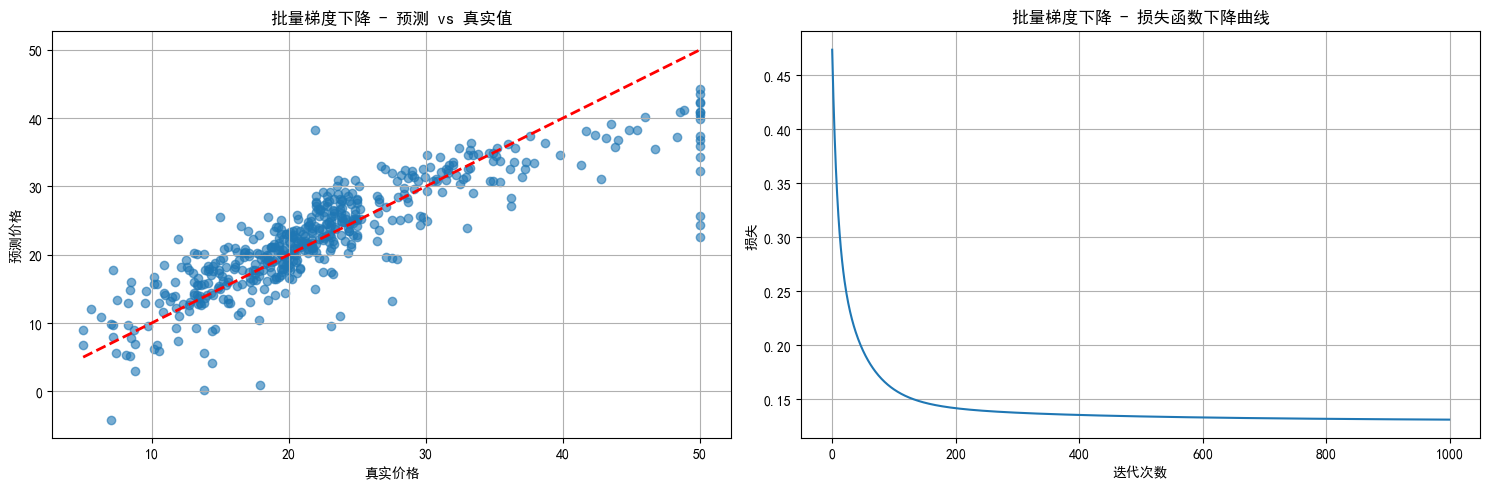

批量梯度下降 最终参数形状: (14, 1)
批量梯度下降 完成!

开始执行: 随机梯度下降
迭代 0: 平均损失 = 0.125293
迭代 100: 平均损失 = 0.097400
迭代 200: 平均损失 = 0.088259
迭代 300: 平均损失 = 0.101113
迭代 400: 平均损失 = 0.109646
迭代 500: 平均损失 = 0.111882
迭代 600: 平均损失 = 0.119449
迭代 700: 平均损失 = 0.089992
迭代 800: 平均损失 = 0.087631
迭代 900: 平均损失 = 0.105343
模型评估结果:
R²分数: 0.7164
均方误差: 23.9416


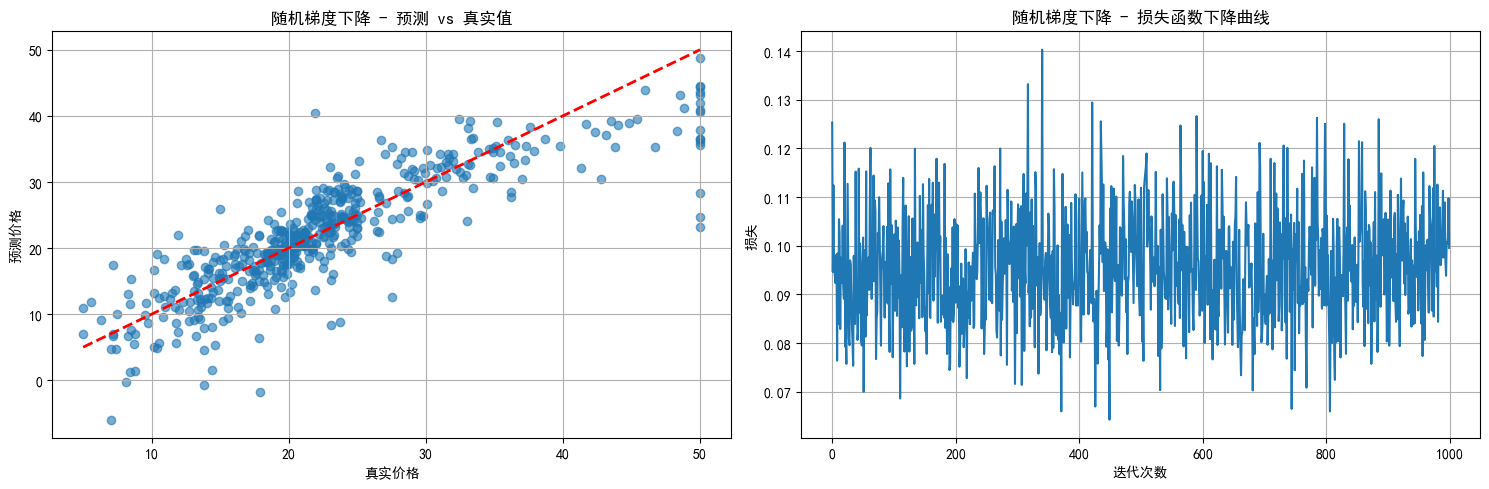

随机梯度下降 最终参数形状: (14, 1)
随机梯度下降 完成!

开始执行: 小批量梯度下降
迭代 0: 平均损失 = 0.355503
迭代 100: 平均损失 = 0.129186
迭代 200: 平均损失 = 0.128004
迭代 300: 平均损失 = 0.127929
迭代 400: 平均损失 = 0.129186
迭代 500: 平均损失 = 0.127704
迭代 600: 平均损失 = 0.128891
迭代 700: 平均损失 = 0.128179
迭代 800: 平均损失 = 0.128725
迭代 900: 平均损失 = 0.129079
模型评估结果:
R²分数: 0.7406
均方误差: 21.8950


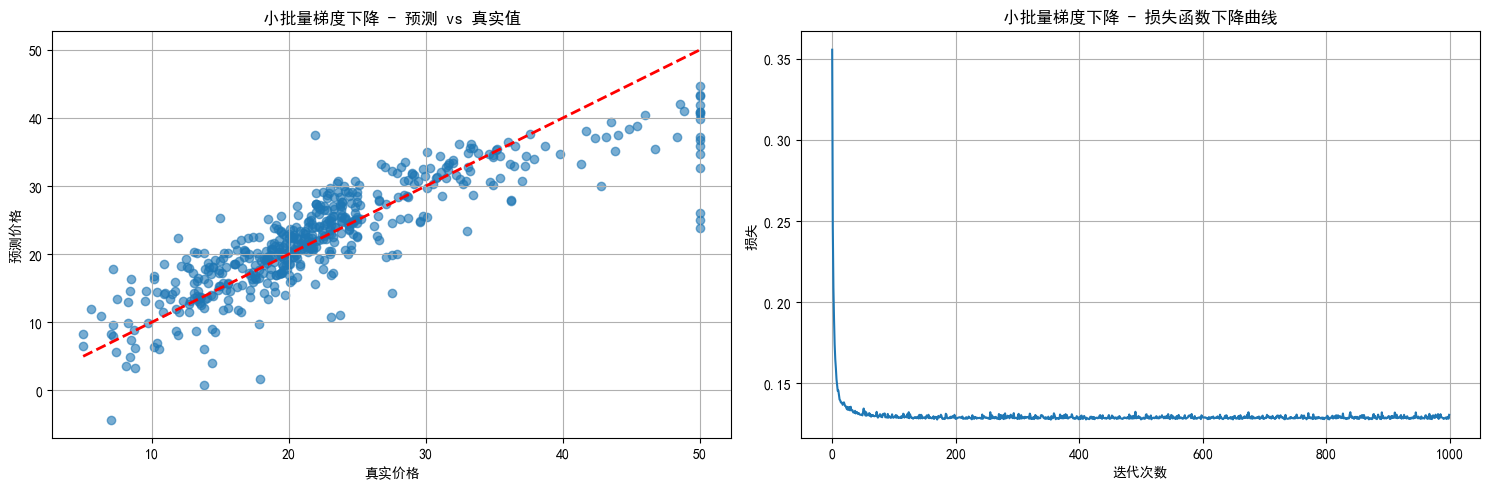

小批量梯度下降 最终参数形状: (14, 1)
小批量梯度下降 完成!

最终结果比较:
闭合形式求解: R² = 0.7406, MSE = 21.8948
批量梯度下降: R² = 0.7374, MSE = 22.1644
随机梯度下降: R² = 0.7164, MSE = 23.9416
小批量梯度下降: R² = 0.7406, MSE = 21.8950

最佳模型: 闭合形式求解 (R² = 0.7406)

特征相关性分析:
特征权重 (标准化后):
        CRIM:  -0.1010 (负相关)
          ZN:   0.1177 (正相关)
       INDUS:   0.0153 (正相关)
        CHAS:   0.0742 (正相关)
         NOX:  -0.2238 (负相关)
          RM:   0.2911 (正相关)
         AGE:   0.0021 (正相关)
         DIS:  -0.3378 (负相关)
         RAD:   0.2897 (正相关)
         TAX:  -0.2260 (负相关)
     PTRATIO:  -0.2243 (负相关)
           B:   0.0924 (正相关)
       LSTAT:  -0.4074 (负相关)

原始数据相关系数:
        CRIM:  -0.3883 (负相关)
          ZN:   0.3604 (正相关)
       INDUS:  -0.4837 (负相关)
        CHAS:   0.1753 (正相关)
         NOX:  -0.4273 (负相关)
          RM:   0.6954 (正相关)
         AGE:  -0.3770 (负相关)
         DIS:   0.2499 (正相关)
         RAD:  -0.3816 (负相关)
         TAX:  -0.4685 (负相关)
     PTRATIO:  -0.5078 (负相关)
           B:   0.3335 (正相关)
       LSTAT:  -0.7377 (负相关

In [23]:
def predict_new_sample(theta, scaler_X, scaler_y, new_features):
    print("开始预测新样本...")
    """使用训练好的模型预测新样本"""
    # 标准化新特征
    new_features_scaled = scaler_X.transform(new_features)
    
    # 添加偏置项
    new_features_scaled = np.hstack([np.ones((new_features_scaled.shape[0], 1)), new_features_scaled])
    
    # 预测（标准化后的结果）
    y_pred_scaled = new_features_scaled.dot(theta)
    
    # 反标准化得到实际价格
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    
    return y_pred

# 主函数
if __name__ == "__main__":
    print("开始线性回归梯度下降分析...")
    
    # 加载数据（用于闭合形式求解）
    boston, X, y = load_and_preprocess_data()
    X_scaled, y_scaled, scaler_X, scaler_y = feature_scaling(X, y)
    
    # 🔥 首先执行闭合形式求解
    print(f"\n{'='*50}")
    print(f"开始执行: 闭合形式求解")
    print(f"{'='*50}")
    
    theta_closed_form = closed_form_solution(X_scaled[:, 1:], y_scaled)  # 去掉偏置项再添加
    y_pred_cf, r2_cf, mse_cf = evaluate_model(X_scaled, y_scaled, theta_closed_form, scaler_y)
    
    # 初始化结果字典
    results = {
        '闭合形式求解': {
            'theta': theta_closed_form,
            'cost_history': [compute_cost(X_scaled, y_scaled, theta_closed_form)],
            'r2': r2_cf,
            'mse': mse_cf,
            'y_pred': y_pred_cf
        }
    }
    
    print(f"闭合形式求解 最终参数形状: {theta_closed_form.shape}")
    print(f"闭合形式求解 完成!")
    
    # 🔥 然后执行梯度下降方法比较
    boston_gd, results_gd, X_scaled_gd, y_scaled_gd, scaler_X_gd, scaler_y_gd = compare_gradient_descent_methods()
    
    # 合并结果
    results.update(results_gd)
    
    # 显示最终比较结果
    print(f"\n{'='*60}")
    print("最终结果比较:")
    print(f"{'='*60}")
    for method_name, result in results.items():
        print(f"{method_name}: R² = {result['r2']:.4f}, MSE = {result['mse']:.4f}")
    
    # 使用最佳模型进行预测示例
    best_method = max(results.items(), key=lambda x: x[1]['r2'])[0]
    best_theta = results[best_method]['theta']
    
    print(f"\n最佳模型: {best_method} (R² = {results[best_method]['r2']:.4f})")
    
    # 特征分析
    feature_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
    feature_weights, correlations = analyze_feature_correlation(boston, best_theta, feature_names)
    
    # 预测新样本示例
    sample_features = np.array([[0.1, 18.0, 2.3, 0, 0.5, 6.5, 65.0, 4.0, 1.0, 300.0, 15.0, 390.0, 10.0]])
    predicted_price = predict_new_sample(best_theta, scaler_X, scaler_y, sample_features)
    
    print(f"\n新样本预测:")
    print(f"输入特征: {sample_features[0]}")
    print(f"预测房价: ${predicted_price[0][0]:.2f}千美元")
    
    # 方法比较总结
    print(f"\n{'='*60}")
    print("方法比较总结:")
    print(f"{'='*60}")
    print("梯度下降 vs 闭合形式求解:")
    print("- 梯度下降: 适合大数据集，可在线学习，需要调参")
    print("- 闭合形式: 适合小数据集，计算精确，可能数值不稳定")
    
    # 🔥 添加性能比较分析
    print(f"\n性能比较分析:")
    cf_r2 = results['闭合形式求解']['r2']
    gd_r2 = results['批量梯度下降']['r2']
    
    if abs(cf_r2 - gd_r2) < 0.01:
        print("- 两种方法性能相近，验证了梯度下降的正确性")
    elif cf_r2 > gd_r2:
        print("- 闭合形式求解略优，梯度下降可能未完全收敛")
    else:
        print("- 梯度下降略优，可能是正则化效应或数值稳定性问题")